In [ ]:
!pip install netCDF4
!pip install livelossplot
from google.colab import drive
drive.mount('/content/gdrive')
import netCDF4 as nc
import numpy as np
import seaborn as sns
import pandas as pd
from shapely.geometry import Polygon
import shapely
import matplotlib.pyplot as plt
import os
from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from keras.objectives import MSE, MAE
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam

In [187]:
x3 = xr.open_dataset('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels/regridded/specific_cloud_liquid_water_content.nc')

station_metadata_df = pd.read_excel('/content/gdrive/MyDrive/rainfall-forecast/station_data/station_list.xlsx', sheet_name = 'combination')
station_data_df = pd.read_csv('/content/gdrive/MyDrive/rainfall-forecast/station_data/final_station_data_daily.csv')
station_data_df = station_data_df.set_index('Unnamed: 0')
precipitation_data = station_data_df.stack(dropna=False).rename('Precipitation').to_frame().rename_axis(['dates', 'station'])

imerg_data_df = pd.DataFrame().reindex_like(station_data_df)

date_range = pd.date_range('2016-01-01', '2020-12-31')
date_fname_list = date_range.strftime('%Y%m%d').to_list()
date_row_list = date_range.strftime('%Y-%m-%d').to_list()

#predictors = os.listdir('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels/regridded')
predictors = ['vorticity.nc']
predictor_names = []
for names in predictors:
  predictor_names.append(names[:-3])

midx = pd.MultiIndex.from_product([date_range, station_data_df.columns])
#mux = pd.MultiIndex.from_product([predictor_names, x3.level.values])
dataframe = pd.DataFrame(index = midx)

In [188]:
files = os.listdir('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels_df')
dfs = []
for file1 in files:
  dfs.append(pd.read_pickle('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels_df/' + file1))

In [195]:
df = pd.DataFrame(files)
df.to_csv('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/predictor_list.csv')

In [197]:
files

['divergence',
 'geopotential',
 'potential_vorticity',
 'ozone_mass_mixing_ratio',
 'fraction_of_cloud_cover',
 'specific_cloud_ice_water_content',
 'specific_cloud_liquid_water_content',
 'relative_humidity',
 'specific_humidity',
 'temperature',
 'u_component_of_wind',
 'specific_snow_water_content',
 'v_component_of_wind',
 'vertical_velocity',
 'vorticity']

In [189]:
#array_list_train_x = np.zeros(shape = (118858, 20, 15))
#array_list_val_x = np.zeros(shape = (18103, 20, 15))
dataset_x = np.zeros(shape = (118858+18103, 20, 15))
i = 0
for file1 in files:
  df = pd.read_pickle('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels_df/' + file1)#.index.set_names(['date', 'station'])
  df = df.rename_axis(['date', 'station'])
  scaler_df = xr.open_dataset('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/pressure_levels/' + file1 + '.nc')
  predictor_var_name = list(scaler_df.keys())[0]
  scaler = MinMaxScaler()
  scaler.fit(scaler_df[predictor_var_name].values.flatten().reshape(-1, 1))
  joblib.dump(scaler, ('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/scalers/' + file1 + '_scaler.gz'))
  df.loc[:, 'precip'] = precipitation_data.values
  df = df.dropna(axis = 0, how = 'any')
  #train = df.loc['2016-01-01':'2020-06-30']
  #val = df.loc['2020-07-01':'2020-12-31']
  #list_values_train = []
  #list_values_val = []
  #for index_train, row_train in train.iterrows():
  #  x_train = scaler.transform(row_train[train.columns[0][0]].values.reshape(-1, 1))
  #  list_values_train.append(x_train.flatten())
  #for index_val, row_val in val.iterrows():
  #  x_val = scaler.transform(row_val[val.columns[0][0]].values.reshape(-1, 1))
  #  list_values_val.append(x_val.flatten())
  
  #array_list_train_x[:, :, i] = list_values_train
  #array_list_val_x[:, :, i] = list_values_val
  list_values = []
  for index, row in df.iterrows():
    x = scaler.transform(row[df.columns[0][0]].values.reshape(-1, 1))
    list_values.append(x.flatten())
  dataset_x[:, :, i] = list_values
  i += 1
  print(file1)


divergence
geopotential
potential_vorticity
ozone_mass_mixing_ratio
fraction_of_cloud_cover
specific_cloud_ice_water_content
specific_cloud_liquid_water_content
relative_humidity
specific_humidity
temperature
u_component_of_wind
specific_snow_water_content
v_component_of_wind
vertical_velocity
vorticity


In [ ]:
array_x = dataset_x[:,:,:].transpose(0,2,1).reshape(len(dataset_x), 15*20)
precip = df['precip'].to_numpy()
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/array_x', array_x)
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/precip', precip)

In [ ]:
array_train_x = array_list_train_x[:,:,:].transpose(0,2,1).reshape(len(array_list_train_x), 15*20)
array_val_x = array_list_val_x[:,:,:].transpose(0,2,1).reshape(len(array_list_val_x), 15*20)
precip_train = train['precip'].to_numpy()
precip_val = val['precip'].to_numpy()
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/train_x', array_train_x)
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/val_x', array_val_x)
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/train_precip', precip_train)
np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/val_precip', precip_val)

**Prepare agricultural dataset**

In [5]:
x = np.load('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/dataframe', allow_pickle = True)
dataset_x = np.zeros(shape = (118858+18103, 20, 15))

files = os.listdir('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/merged_datasets')

In [6]:
files

['merged_aggWind-Speed-10m-Mean.nc',
 'merged_aggVapour-Pressure-Mean.nc',
 'merged_aggSolar-Radiation-Flux.nc',
 'merged_aggCloud-Cover-Mean.nc',
 'merged_aggTemperature-Air-2m-Mean-24h.nc',
 'merged_aggRelative-Humidity-2m-12h.nc']

In [142]:
for file1 in files:
  scaler_df = xr.open_dataset('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/merged_datasets/' + file1)
  predictor_var_name = list(scaler_df.keys())[0]
  scaler = MinMaxScaler()
  scaler.fit(scaler_df[predictor_var_name].values.flatten().reshape(-1, 1))
  joblib.dump(scaler, ('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/scalers_agr/' + file1 + '_scaler.gz'))

  x[[file1[:-3]]] = scaler.transform(x[[file1[:-3]]])


In [143]:
x.loc[:,'precip'] = precipitation_data.values
x = x.dropna(axis = 0, how = 'any')
#np.save('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/dataframe_normalized', x)
x.to_pickle('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/dataframe_normalized.pkl')

**Start here for MLP**

In [3]:
x = np.load('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/array_x.npy')
precip = np.load('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/train_test/precip.npy')

In [4]:
x

array([[0.5029985 , 0.5058978 , 0.5064624 , ..., 0.81801536, 0.81645891,
        0.81699298],
       [0.51261198, 0.49790183, 0.5054858 , ..., 0.75749623, 0.75662645,
        0.75680957],
       [0.50376147, 0.50478386, 0.50655396, ..., 0.79651475, 0.79451575,
        0.79446997],
       ...,
       [0.49459052, 0.5406284 , 0.45709796, ..., 0.74998858, 0.75134667,
        0.75168238],
       [0.50159463, 0.49996186, 0.47553142, ..., 0.7512246 , 0.75305574,
        0.75377293],
       [0.50659974, 0.50460075, 0.48613677, ..., 0.72667209, 0.74293868,
        0.74225202]])

In [171]:
x = pd.read_pickle('/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid/ERA5/agr_data/dataframe_normalized.pkl')
precip = x.precip.values
x = x.drop(columns = 'precip')
x = x.to_numpy().astype('float32')

In [184]:
dropout = 0.5
dense_layer_size = 64
model = Sequential()
model.add(Input(x.shape[1]))
model.add(Dense(dense_layer_size, activation = 'tanh'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(dense_layer_size, activation = 'tanh'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(dense_layer_size, activation = 'tanh'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))
#model.add(Dense(dense_layer_size, activation = 'tanh'))
#model.add(BatchNormalization())
#model.add(Dropout(dropout))
model.add(Dense(1, activation = 'relu'))
opt = Adam(0.0001)
model.compile(optimizer = opt, loss = "mse")

In [166]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

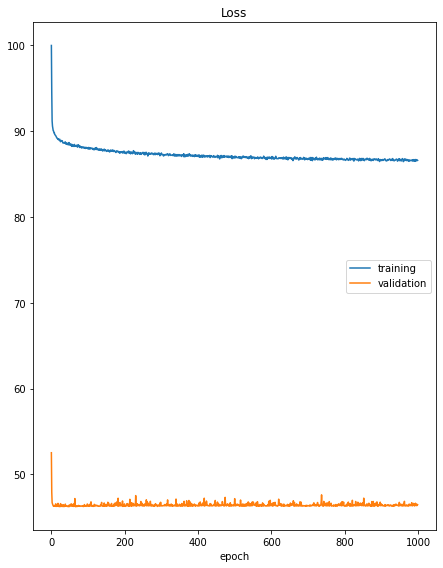

Loss
	training         	 (min:   86.431, max:   99.959, cur:   86.574)
	validation       	 (min:   46.241, max:   52.532, cur:   46.479)


In [185]:
checkpoint_filepath = '/content/gdrive/MyDrive/rainfall-forecast/merge_model/populate_grid'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=200)
train_log = model.fit(x, precip, validation_split = 0.15, shuffle = True, batch_size = 256, epochs = 1000, verbose=False, callbacks=[PlotLossesKeras(), model_checkpoint_callback])